### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [1]:
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
import nltk
import tensorflow as ts
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
data = pd.read_csv("./resource/Train_rev1.csv", index_col=None)
data.shape

data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"


tokenizer = nltk.tokenize.WordPunctTokenizer()
data['Title'] = data['Title'].apply(lambda x: (' ').join(tokenizer.tokenize(str(x).lower())))
data['FullDescription'] = data['FullDescription'].apply(lambda x: (' ').join(tokenizer.tokenize(str(x).lower())))



In [3]:
token_counts = Counter()
for title in data['Title']:
    token_counts.update(Counter(tokenizer.tokenize(title)))
for title in data['FullDescription']:
    token_counts.update(Counter(tokenizer.tokenize(title)))
    
min_count = 10
# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [key for key in token_counts.keys() if token_counts[key]>=min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

token_to_id = {key:index for index,key in enumerate(tokens)}


Vocabulary size: 34158


In [4]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences)) # split each element in sequence by " "(space)
        
    max_len = min(max(map(len, sequences)), max_len or float('inf')) # get the maximum sequence length
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX)) # Create a matrix #sequence * max_len with default value:pad
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]] # For each seq, replace the word into index
        matrix[i, :len(row_ix)] = row_ix # Update the matrix
    
    return matrix

In [5]:
# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [6]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [10]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [11]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = layers.Input(shape=[None], name="Title")
    l_descr = layers.Input(shape=[None], name="FullDescription")
    l_categ = layers.Input(shape=[n_cat_features], name="Categorical")
    
    # Build your monster!
    
    # <YOUR CODE>
    #title
    title_emb = layers.Embedding(n_tokens, 8)(l_title) # batch*input -> batch*input*8
    title_con1 = layers.Conv1D(filters=16, kernel_size=3, activation='relu',padding='same')(title_emb) #batch*input*8-> batch*input*16 [padding=valid: batch*input-2*(kernel_size//2)*filter / padding=same: batch*input*filter]
    title_pool1 = layers.GlobalMaxPooling1D(data_format="channels_last")(title_con1) #batch*input*16 -> batch*16
#     title_flatten = layers.Flatten(data_format='channels_last')(title_pool1)
    
    #descr
    descr_emb = layers.Embedding(n_tokens, 8)(l_descr)# batch*input -> batch*input*8
    descr_con1 = layers.Conv1D(filters=16, kernel_size=3, activation='relu',padding='same')(descr_emb)
    descr_pool1 = layers.GlobalMaxPooling1D(data_format="channels_last")(descr_con1)
    
    #categ
    categ_d1 = layers.Dense(units=64, activation='relu')(l_categ)
    categ_d2 = layers.Dense(units=128, activation='relu')(categ_d1)
    
    concat = layers.Concatenate(axis=1)([title_pool1, descr_pool1, categ_d2])
    dense1 = layers.Dense(units=64, activation='relu')(concat)
    dense2 = layers.Dense(units=32, activation='relu')(dense1)
    dense3 = layers.Dense(units=16, activation='relu')(dense2)
    
    output_layer = layers.Dense(units=1, activation='relu')(dense3)
    # end of your code
    
    model = ts.keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break
            
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error
            
def draw_model_loss(history):

    mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(mae))

    plt.plot(epochs, mae, 'r', label='Training MAE')
    plt.plot(epochs, val_mae, 'b', label='Validation MAE')
    plt.title('Training and validation MAE')

    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Base model

In [12]:
batch_size = 256
epochs = 10            # definitely too small
steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

model = build_model()

base_history = model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size
                   )

Epoch 1/10


/var/folders/hc/mx19r91j1ms05m9rf9bljc980000gn/T/ipykernel_47568/3034673819.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  base_history = model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05),


100/100 [==============================] - 6s 53ms/step - loss: 28.2247 - mean_absolute_error: 3.5750 - val_loss: 0.2493 - val_mean_absolute_error: 0.3919
Epoch 2/10
100/100 [==============================] - 5s 50ms/step - loss: 0.1898 - mean_absolute_error: 0.3396 - val_loss: 0.1567 - val_mean_absolute_error: 0.3079
Epoch 3/10
100/100 [==============================] - 5s 53ms/step - loss: 0.1462 - mean_absolute_error: 0.2950 - val_loss: 0.1315 - val_mean_absolute_error: 0.2803
Epoch 4/10
100/100 [==============================] - 5s 51ms/step - loss: 0.1245 - mean_absolute_error: 0.2699 - val_loss: 0.1193 - val_mean_absolute_error: 0.2635
Epoch 5/10
100/100 [==============================] - 5s 51ms/step - loss: 0.1172 - mean_absolute_error: 0.2586 - val_loss: 0.1085 - val_mean_absolute_error: 0.2508
Epoch 6/10
100/100 [==============================] - 5s 55ms/step - loss: 0.1075 - mean_absolute_error: 0.2488 - val_loss: 0.1013 - val_mean_absolute_error: 0.2408
Epoch 7/10
100/100 [

In [13]:
print_metrics(model, data_train, name='Train')
print_metrics(model, data_val, name='Val');

8/8 [==============================] - 0s 894us/step
Train results:
Mean square error: 0.08125
Mean absolute error: 0.21304
2/2 [==============================] - 0s 1ms/step
Val results:
Mean square error: 0.08765
Mean absolute error: 0.22226


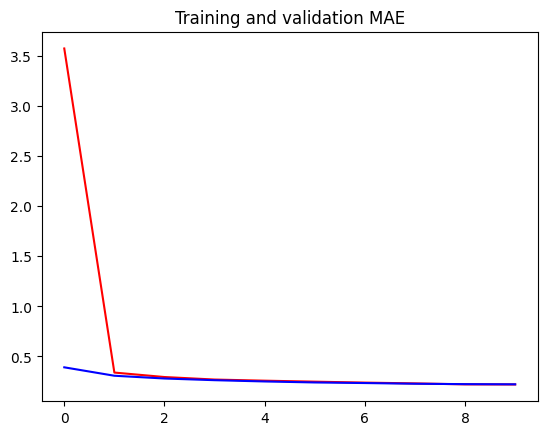

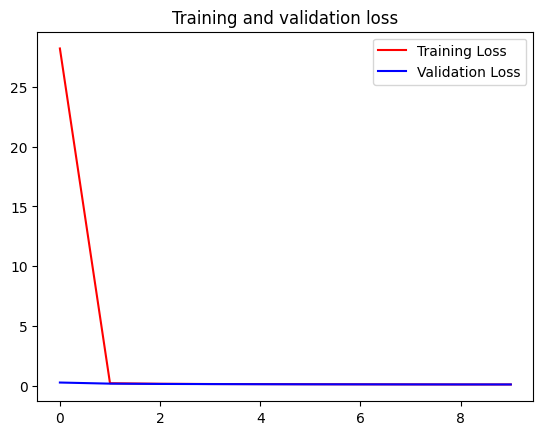

In [14]:
draw_model_loss(base_history)

---

In [17]:
def run_model(model_build_func, **kwargs):

    batch_size = 256
    epochs = 10            # definitely too small
    steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

    model = model_build_func(**kwargs)
    print(**kwargs)
    model.summary()

    base_history = model.fit(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                        epochs=epochs, steps_per_epoch=steps_per_epoch,
                        
                        validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                        validation_steps=data_val.shape[0] // batch_size
                       )

    draw_model_loss(base_history)

# A) CNN architecture 

1. Apply `Dropout` layer  
2. Apply `BatchNormalization` layer

In [15]:
def build_model_a(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64, dropout_rate=0):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = layers.Input(shape=[None], name="Title")
    l_descr = layers.Input(shape=[None], name="FullDescription")
    l_categ = layers.Input(shape=[n_cat_features], name="Categorical")
    
    # Build your monster!
    
    #title
    title_emb = layers.Embedding(n_tokens, 8)(l_title) # batch*input -> batch*input*8
    title_con1 = layers.Conv1D(filters=16, kernel_size=3, activation='relu',padding='same')(title_emb) #batch*input*8-> batch*input*16 [padding=valid: batch*input-2*(kernel_size//2)*filter / padding=same: batch*input*filter]
    title_bn1 = layers.BatchNormalization()(title_con1)
    title_pool1 = layers.GlobalMaxPooling1D(data_format="channels_last")(title_bn1) #batch*input*16 -> batch*16
    # para conv
    title_con2 = layers.Conv1D(filters=16, kernel_size=2, activation='relu',padding='same')(title_emb) #batch*input*8-> batch*input*16 [padding=valid: batch*input-2*(kernel_size//2)*filter / padding=same: batch*input*filter]
    title_bn2 = layers.BatchNormalization()(title_con2)
    title_pool2 = layers.GlobalMaxPooling1D(data_format="channels_last")(title_bn2) # batch*16
    
    #descr
    descr_emb = layers.Embedding(n_tokens, 8)(l_descr)# batch*input -> batch*input*8
    descr_con1 = layers.Conv1D(filters=16, kernel_size=3, activation='relu',padding='same')(descr_emb)
    descr_bn1 = layers.BatchNormalization()(descr_con1)
    descr_pool1 = layers.GlobalMaxPooling1D(data_format="channels_last")(descr_bn1)
    # parallel con
    descr_con2 = layers.Conv1D(filters=16, kernel_size=2, activation='relu',padding='same')(descr_emb) #batch*input*8-> batch*input*16
    descr_bn2 = layers.BatchNormalization()(descr_con2)
    descr_pool2 = layers.GlobalMaxPooling1D(data_format="channels_last")(descr_bn2)
    
    #categ
    categ_d1 = layers.Dense(units=1024, activation='relu')(l_categ)
    categ_dropout1 = layers.Dropout(dropout_rate)(categ_d1)
    categ_d2 = layers.Dense(units=512, activation='relu')(categ_dropout1)
    categ_dropout2 = layers.Dropout(dropout_rate)(categ_d2)
    categ_d3 = layers.Dense(units=256, activation='relu')(categ_dropout2)
    
    concat = layers.Concatenate(axis=1)([title_pool1, title_pool2, descr_pool1, descr_pool2, categ_d2])
    dense1 = layers.Dense(units=256, activation='relu')(concat)
    dropout1 = layers.Dropout(dropout_rate)(dense1)
    dense2 = layers.Dense(units=256, activation='relu')(dropout1)
    dropout2 = layers.Dropout(dropout_rate)(dense2)
    dense3 = layers.Dense(units=128, activation='relu')(dropout2)
    dropout3 = layers.Dropout(dropout_rate)(dense3)
    dense4 = layers.Dense(units=64, activation='relu')(dropout3)
    dropout4 = layers.Dropout(dropout_rate)(dense4)
    dense5 = layers.Dense(units=32, activation='relu')(dropout4)
    dense6 = layers.Dense(units=16, activation='relu')(dense5)
    
    output_layer = layers.Dense(units=1, activation='relu')(dense6)
    # end of your code
    
    model = ts.keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

Epoch 1/10


/var/folders/hc/mx19r91j1ms05m9rf9bljc980000gn/T/ipykernel_47568/4231251656.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  base_history = model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05),


100/100 [==============================] - 8s 76ms/step - loss: 6.5966 - mean_absolute_error: 1.6641 - val_loss: 66.1131 - val_mean_absolute_error: 8.1177
Epoch 2/10
100/100 [==============================] - 8s 78ms/step - loss: 0.8803 - mean_absolute_error: 0.7409 - val_loss: 58.4257 - val_mean_absolute_error: 7.6305
Epoch 3/10
100/100 [==============================] - 8s 85ms/step - loss: 0.7041 - mean_absolute_error: 0.6629 - val_loss: 49.9849 - val_mean_absolute_error: 7.0564
Epoch 4/10
100/100 [==============================] - 9s 88ms/step - loss: 0.5774 - mean_absolute_error: 0.5993 - val_loss: 41.9116 - val_mean_absolute_error: 6.4601
Epoch 5/10
100/100 [==============================] - 8s 85ms/step - loss: 0.5469 - mean_absolute_error: 0.5837 - val_loss: 36.0976 - val_mean_absolute_error: 5.9953
Epoch 6/10
100/100 [==============================] - 9s 88ms/step - loss: 0.4810 - mean_absolute_error: 0.5454 - val_loss: 22.4979 - val_mean_absolute_error: 4.7291
Epoch 7/10
100/

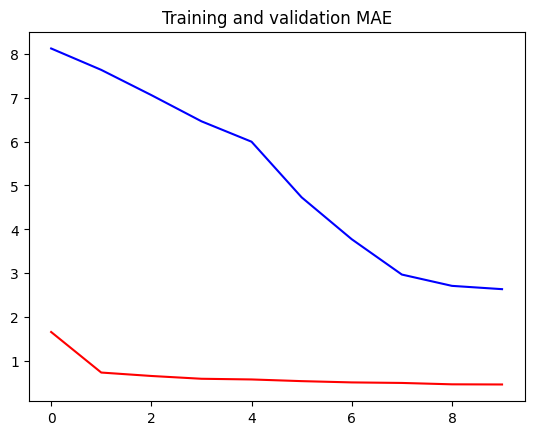

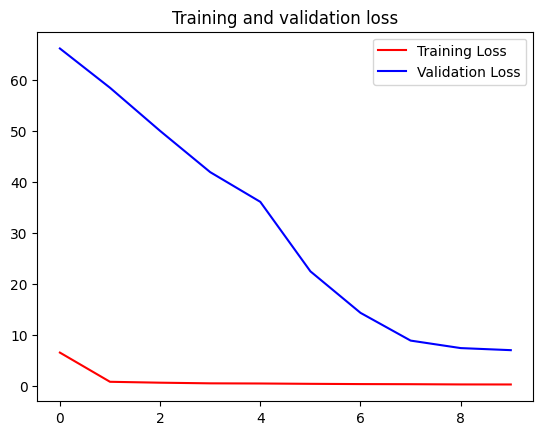

In [18]:
# Apply dropout
run_model(build_model_a, dropout_rate=0.1)

{'dropout_rate': 0.1}
<function build_model_a at 0x139fd6550>
Epoch 1/10
100/100 [==============================] - 24s 230ms/step - loss: 18.7607 - mean_absolute_error: 3.0841 - val_loss: 59.8551 - val_mean_absolute_error: 7.7224
Epoch 2/10
100/100 [==============================] - 33s 333ms/step - loss: 1.1581 - mean_absolute_error: 0.8532 - val_loss: 54.1842 - val_mean_absolute_error: 7.3471
Epoch 3/10
100/100 [==============================] - 28s 286ms/step - loss: 0.8109 - mean_absolute_error: 0.7156 - val_loss: 49.8330 - val_mean_absolute_error: 7.0464
Epoch 4/10
100/100 [==============================] - 24s 238ms/step - loss: 0.8185 - mean_absolute_error: 0.7190 - val_loss: 39.8611 - val_mean_absolute_error: 6.3001
Epoch 5/10
100/100 [==============================] - 24s 240ms/step - loss: 0.6212 - mean_absolute_error: 0.6228 - val_loss: 30.3367 - val_mean_absolute_error: 5.4945
Epoch 6/10
100/100 [==============================] - 25s 249ms/step - loss: 0.5055 - mean_absolu

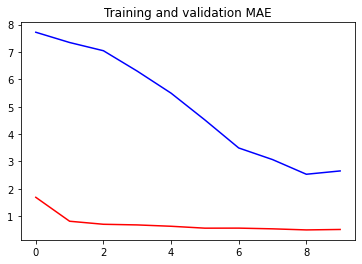

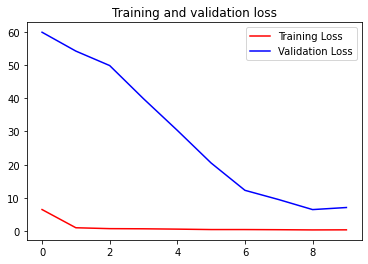

In [48]:
# Apply dropout + BN + more dense layers
run_model(build_model_a, dropout_rate=0.1)

{'dropout_rate': 0.1}
<function build_model_a at 0x13a1780d0>
Epoch 1/10
100/100 [==============================] - 33s 309ms/step - loss: 20.6402 - mean_absolute_error: 3.2191 - val_loss: 68.6544 - val_mean_absolute_error: 8.2731
Epoch 2/10
100/100 [==============================] - 32s 316ms/step - loss: 1.0597 - mean_absolute_error: 0.8128 - val_loss: 62.5165 - val_mean_absolute_error: 7.8942
Epoch 3/10
100/100 [==============================] - 35s 349ms/step - loss: 0.9113 - mean_absolute_error: 0.7548 - val_loss: 52.5389 - val_mean_absolute_error: 7.2350
Epoch 4/10
100/100 [==============================] - 37s 373ms/step - loss: 0.7599 - mean_absolute_error: 0.6926 - val_loss: 48.2539 - val_mean_absolute_error: 6.9340
Epoch 5/10
100/100 [==============================] - 40s 397ms/step - loss: 0.6240 - mean_absolute_error: 0.6246 - val_loss: 36.6009 - val_mean_absolute_error: 6.0375
Epoch 6/10
100/100 [==============================] - 40s 406ms/step - loss: 0.5259 - mean_absolu

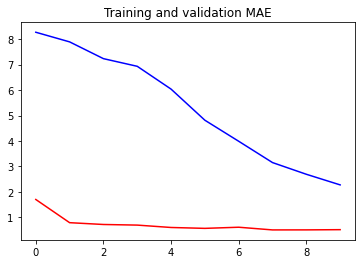

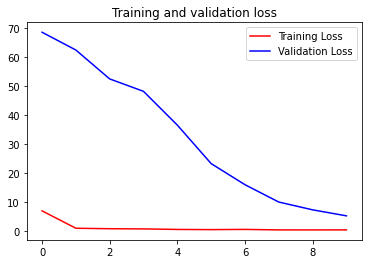

In [50]:
# Apply dropout + BN + more dense layers + parallel conv
run_model(build_model_a, dropout_rate=0.1)

{'dropout_rate': 0.1}
<function build_model_a at 0x139da6550>
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
FullDescription (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, None, 8)      273264      Title[0][0]                      
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, None, 8)      273264      FullDescription[0][0]            
______________________________

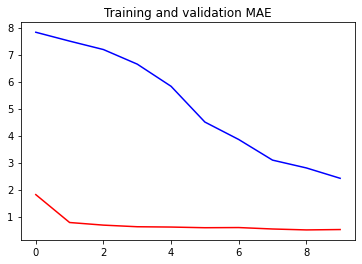

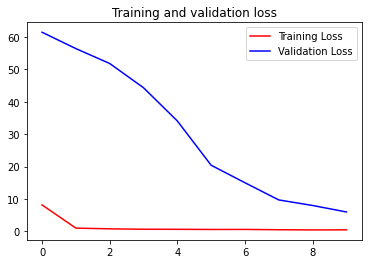

In [54]:
# Apply dropout + BN + more dense layers + parallel conv
run_model(build_model_a, dropout_rate=0.1)

In [53]:
def run_model(build_model_func, **kwargs):
    print(kwargs)
    print(build_model_func)

    batch_size = 256
    epochs = 10            # definitely too small
    steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

    model = build_model_func(**kwargs)
    model.summary()

    history = model.fit(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                        epochs=epochs, steps_per_epoch=steps_per_epoch,

                        validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                        validation_steps=data_val.shape[0] // batch_size
                       )
    print_metrics(model, data_train, name='Train')
    print_metrics(model, data_val, name='Val')
    draw_model_loss(history)

# D) RNN

In [19]:
def build_model_d(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64, dropout_rate=0):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = layers.Input(shape=[None], name="Title")
    l_descr = layers.Input(shape=[None], name="FullDescription")
    l_categ = layers.Input(shape=[n_cat_features], name="Categorical")
    
    # Build your monster!
    #title
    title_emb = layers.Embedding(n_tokens, 32)(l_title) # batch*input -> batch*input*32
    title_lstm1 = layers.LSTM(64)(title_emb)
    title_d1 = layers.Dense(units=64, activation='relu')(title_lstm1)
    
    #descr
    descr_emb = layers.Embedding(n_tokens, 32)(l_descr) # batch*input -> batch*input*32
    descr_lstm1 = layers.LSTM(128)(descr_emb)
    descr_d1 = layers.Dense(units=128, activation='relu')(descr_lstm1)
    
    #categ
    categ_d1 = layers.Dense(units=1024, activation='relu')(l_categ)
    categ_dropout1 = layers.Dropout(dropout_rate)(categ_d1)
    categ_d2 = layers.Dense(units=512, activation='relu')(categ_dropout1)
    categ_dropout2 = layers.Dropout(dropout_rate)(categ_d2)
    categ_d3 = layers.Dense(units=256, activation='relu')(categ_dropout2)
    
    
    concat = layers.Concatenate(axis=1)([title_d1, descr_d1, categ_d3])
    dense1 = layers.Dense(units=256, activation='relu')(concat)
    dropout1 = layers.Dropout(dropout_rate)(dense1)
    dense2 = layers.Dense(units=256, activation='relu')(dropout1)
    dropout2 = layers.Dropout(dropout_rate)(dense2)
    dense3 = layers.Dense(units=128, activation='relu')(dropout2)
    dropout3 = layers.Dropout(dropout_rate)(dense3)
    dense4 = layers.Dense(units=64, activation='relu')(dropout3)
    dropout4 = layers.Dropout(dropout_rate)(dense4)
    dense5 = layers.Dense(units=32, activation='relu')(dropout4)
    dense6 = layers.Dense(units=16, activation='relu')(dense5)
    
    output_layer = layers.Dense(units=1, activation='relu')(dense6)
    # end of your code
    
    model = ts.keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

Epoch 1/10


/var/folders/hc/mx19r91j1ms05m9rf9bljc980000gn/T/ipykernel_47568/4231251656.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  base_history = model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05),


100/100 [==============================] - 313s 3s/step - loss: 12.1436 - mean_absolute_error: 2.2510 - val_loss: 1.5285 - val_mean_absolute_error: 1.1228
Epoch 2/10
100/100 [==============================] - 327s 3s/step - loss: 1.2081 - mean_absolute_error: 0.8687 - val_loss: 3.9979 - val_mean_absolute_error: 1.9452
Epoch 3/10
100/100 [==============================] - 6599s 67s/step - loss: 0.8304 - mean_absolute_error: 0.7199 - val_loss: 3.0775 - val_mean_absolute_error: 1.7061
Epoch 4/10
100/100 [==============================] - 319s 3s/step - loss: 0.6743 - mean_absolute_error: 0.6491 - val_loss: 5.4128 - val_mean_absolute_error: 2.2966
Epoch 5/10
100/100 [==============================] - 330s 3s/step - loss: 0.5760 - mean_absolute_error: 0.5970 - val_loss: 5.8281 - val_mean_absolute_error: 2.3889
Epoch 6/10
100/100 [==============================] - 317s 3s/step - loss: 0.5773 - mean_absolute_error: 0.6032 - val_loss: 6.1361 - val_mean_absolute_error: 2.4511
Epoch 7/10
100/100

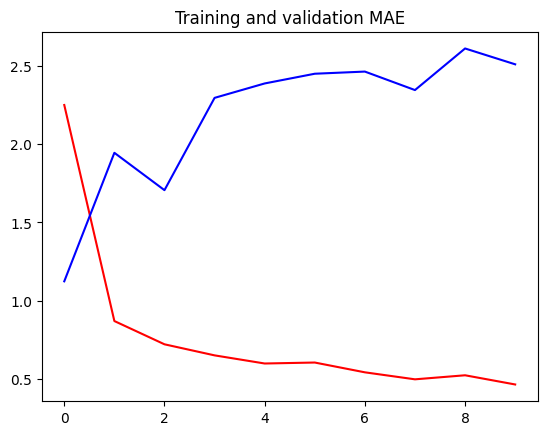

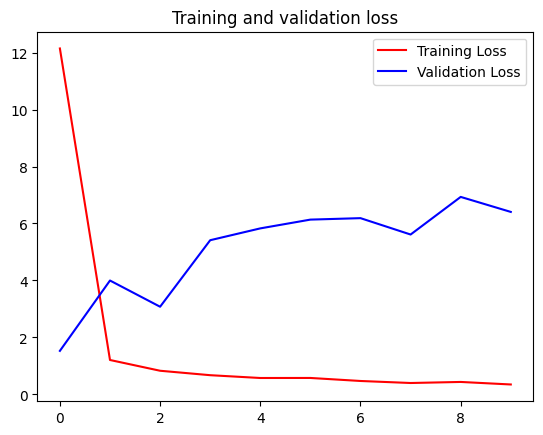

In [20]:
# Apply basic RNN
run_model(build_model_d, dropout_rate=0.1)

In [21]:
print('test')

test


{'dropout_rate': 0.1}
<function build_model_d at 0x13a560e50>
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Categorical (InputLayer)        [(None, 3768)]       0                                            
__________________________________________________________________________________________________
dense_69 (Dense)                (None, 1024)         3859456     Categorical[0][0]                
__________________________________________________________________________________________________
Title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
FullDescription (InputLayer)    [(None, None)]       0                                            
______________________________

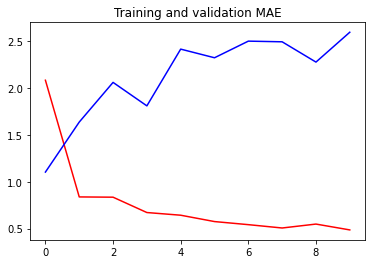

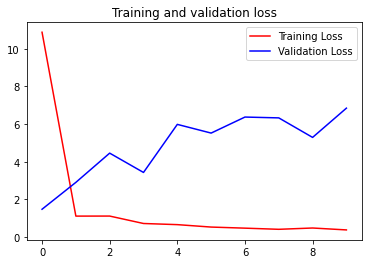

In [60]:
# Apply basic RNN
run_model(build_model_d, dropout_rate=0.1)

In [ ]:
# < A whole lot of your code > - models, charts, analysis

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!